# Inequality constraints with *refnx*

Simple equality constraints can use the mechanisms outlined in this notebook, but are better expressed using the `Parameter.constraint` mechanism, or by sharing `Parameter` objects. It is sometimes also possible to implement different parameterisation of the model to use physically relevant values.

The following processes can be used to make inequality constraints with *refnx*. The dataset is reflectivity from a clean silicon wafer with a native oxide layer.

In [1]:
%matplotlib inline
import os.path
import numpy as np

import refnx
from refnx.dataset import ReflectDataset
from refnx.reflect import SLD, MaterialSLD, ReflectModel
from refnx.analysis import Objective, CurveFitter

np.random.seed(1)

In [2]:
pth = os.path.dirname(refnx.__file__)
DATASET_NAME = 'c_PLP0000708.dat'
file_path = os.path.join(pth, 'dataset', 'test', DATASET_NAME)

data = ReflectDataset(file_path)

In [3]:
air = SLD(0)
sio2 = MaterialSLD('SiO2', 2.2)
si = MaterialSLD('Si', 2.33)
s = air | sio2(15, 3) | si(0, 3)

model = ReflectModel(s, bkg=3e-8)

In [4]:
# model.bkg.setp(vary=True, bounds=(0, 1e-6))
# model.scale.setp(vary=True, bounds=(0.9, 1.1))

# sio2 layer
s[1].rough.setp(vary=True, bounds=(0, 10))
s[1].thick.setp(vary=True, bounds=(0, 20))

# si/sio2 interface
s[-1].rough.setp(vary=True, bounds=(0, 10))

In [5]:
objective = Objective(model, data)
fitter = CurveFitter(objective)

In [6]:
fitter.fit('differential_evolution')
print(s)

-24.62789421854312: : 18it [00:00, 112.74it/s] 

________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:   ' - sld'    , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=10.1024 +/- 0.411, bounds=[0.0, 20.0]>
________________________________________________________________________________
Parameters:       ''

## Inequality constraints with `differential_evolution`

*Simple equality constraints can use the following mechanism, but are better expressed using the `Parameter.constraint` mechanism, or by sharing `Parameter` objects. It is sometimes also possible to implement different parameterisation of the model to use physically relevant values.*

We see that the thickness of the SiO2 layer is 12.45 and the roughness of the air/SiO2 interface is 4.77. Let's make a constraint that the roughness can't be more than a quarter of the layer thickness. In optimisation such constraints are expressed as inequalities:

$t > 4\sigma$

We need to rearrange so that all variables are on one side, we do the rearrangement like this so there is no divide by 0:

$t - 4\sigma > 0$

Now we create a callable object (has the `__call__` magic method) that encodes this inequality. We're going to create the object with the parameters we want to constrain (`pars`), so we can refer to them later. We'll also store the objective because we'll need to update it with the fitting parameters.

In [7]:
class DEC(object):
    def __init__(self, pars, objective):
        # we'll store the parameters and objective in this object
        # this will be necessary for pickling in the future
        self.pars = pars
        self.objective = objective

    def __call__(self, x):
        # we need to update the varying parameters in the
        # objective first
        self.objective.setp(x)
        return float(self.pars[0] - 4*self.pars[1])

Now lets create an instance of that object, using the parameters we want to constrain. Following that we set up a `scipy.optimize.NonlinearConstraint` for use with `differential_evolution`. Note that we want the constraint calculation to be greater than 0.

In [8]:
pars = (s[1].thick, s[1].rough)
dec = DEC(pars, objective)

from scipy.optimize import NonlinearConstraint
constraint = NonlinearConstraint(dec, 0, np.inf)

Now do the fit with the added constraint. Note that you can have more than one constraint.

In [9]:
np.random.seed(1)
fitter.fit('differential_evolution', constraints=(constraint,))
print(s)

-24.51333095283976: : 33it [00:00, 146.53it/s] /Users/andrew/miniconda3/envs/dev3/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/Users/andrew/miniconda3/envs/dev3/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
-24.51333095283976: : 33it [00:00, 90.88it/s] 

________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:   ' - sld'    , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=9.93053 +/- 0.387, bounds=[0.0, 20.0]>
________________________________________________________________________________
Parameters:       ''

## Inequality constraints during MCMC sampling

If we want to implement that inequality constraint during sampling we can add an extra log-probability term to the `Objective`. This log-probability term will return 0 if the inequality is satisfied, but `-np.inf` if not.

In [10]:
class LogpExtra(object):
    def __init__(self, pars):
        # we'll store the parameters and objective in this object
        # this will be necessary for pickling in the future
        self.pars = pars

    def __call__(self, model, data):
        if float(self.pars[0] - 4*self.pars[1]) > 0:
            return 0
        return -np.inf

In [11]:
lpe = LogpExtra(pars)

# set the log_extra attribute of the Objective with our extra log-probability term.
objective.logp_extra = lpe

Lets check what happens to the probabilities with the specified inequality.

In [12]:
print(s[1].thick)
print(s[1].rough)
print(objective.logpost())

print("Now exceed the inequality")
s[1].rough.value = 5.
print(objective.logpost())

<Parameter:  ' - thick'   , value=9.93053 +/- 0.387, bounds=[0.0, 20.0]>
<Parameter:  ' - rough'   , value=2.48263 +/- 0.394, bounds=[0.0, 10.0]>
16.92539558662436
Now exceed the inequality
-inf


Now let's MCMC sample the system. There will be a user warning because some walkers have initial starting points which disobey the inequality. Normally one would sample for a far longer time, and thin more appropriately. However, the purpose of the following is to produce a corner plot that demonstrates the inequality - note the sharp dropoff in the probability distribution for the roughness. The roughness doesn't like to go much higher than ~2.5, which is around a quarter of the optimal layer thickness of ~10.

  0%|                                                                                                                          | 0/200 [00:00<?, ?it/s]/Users/andrew/miniconda3/envs/dev3/lib/python3.12/site-packages/refnx/_lib/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.49it/s]


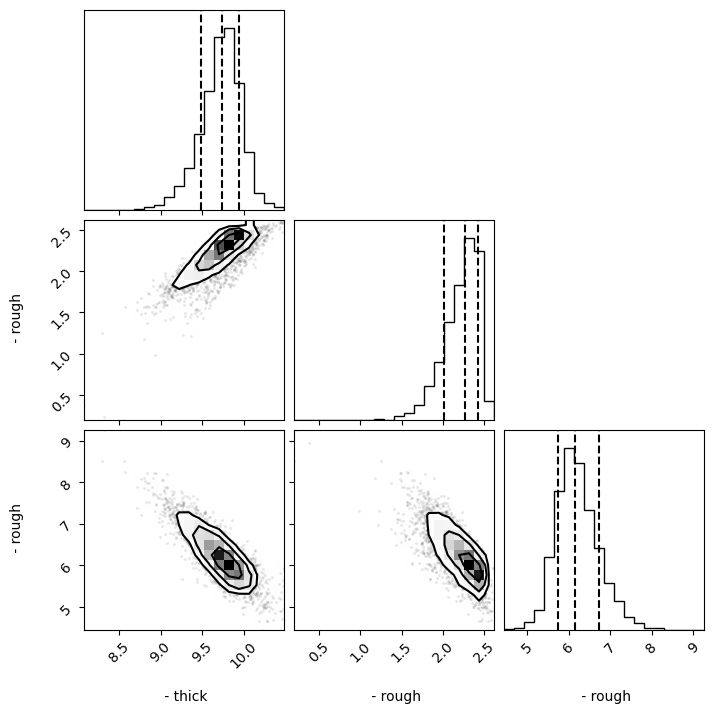

In [13]:
s[1].rough.value = 2.
fitter.initialise('covar')
fitter.sample(20, nthin=10, pool=1);
objective.corner();